In [645]:
#--------------------------------------
# general imports
#--------------------------------------
import numpy as np
from astropy import utils, io
from astropy.table import Table, join
import matplotlib as mpl
from getpass import getpass
from astropy.visualization import make_lupton_rgb
from __future__ import print_function #to use print() as a func. in py2
import pylab
from sklearn.preprocessing import Normalizer

%matplotlib inline

#--------------------------------------
# for clustering modules
#--------------------------------------
from sklearn.cluster import DBSCAN
from sklearn import mixture
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import itertools
from scipy import linalg
import matplotlib.pyplot as plt

#--------------------------------------
# Datalab and related imports
#--------------------------------------
# need these for authenticating and for issuing database queries
from dl import authClient as ac, queryClient as qc
# need storeClient to use virtual storage or myDB
# Get helpers for various convenience function
from dl import storeClient as sc
from dl.helpers.utils import convert

In [647]:
#--------------------------------------
# Get token from NOAO datalab
#--------------------------------------
try:
    input = raw_input
except NameError:
    pass
token = ac.login(input("Enter user name: "),getpass("Enter password: "))
if not ac.isValidToken (token):
    print ('nnnnnope (%s)' % token)
else:
    print ("Login token:   %s" % token)

Enter user name: katiefasbender
Enter password: ········
Login token:   katiefasbender.1579.1579.$1$jhF.53l2$51rQiEieDElzi.c.IQw8v1


In [648]:
#A radial query of NSC measurement table
dat_m=qc.query(token,sql='select * from nsc_dr1.meas where q3c_radial_query(ra,dec,201.35,-15.74,.05)',fmt='table')
X=np.column_stack((np.array(dat_m['ra']),np.array(dat_m['dec'])))  #set of (RA,DEC) coordinates
X_time=np.column_stack((np.array(dat_m['ra']),np.array(dat_m['dec']),np.array(dat_m['mjd'])))  #set of (RA,DEC,MJD) coordinates

#Same radial query of existing NSC object table, for reference
dat_o=qc.query(token,sql='select * from nsc_dr1.object where q3c_radial_query(ra,dec,201.35,-15.74,.05)',fmt='table')

Function to plot DBSCAN results

In [650]:
def plot_dbscan(X,db,pltt,data=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's labels (indicating which cluster they're in); -1 means it's an outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"
    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor=(0,0,0,.5), markersize=6)

        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor='k', markersize=6)

    if pltt==plt:
        pltt.title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
    else: pltt.set_title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))

# DBSCAN on NSC Measurements Table

In [651]:
#scale of eps used (without time) to reference when normalizing data
(max(dat_m['ra'])-min(dat_m['ra']))/0.000138889

720.1514372844229

## DBSCAN with and without time
no data normalization 

In [652]:
# Compute DBSCAN, one with and without time---------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(X)#dbscan without time
db_t = DBSCAN(eps=0.005, min_samples=2).fit(X_time) #dbscan with time - multiple eps were tried, none work very well 

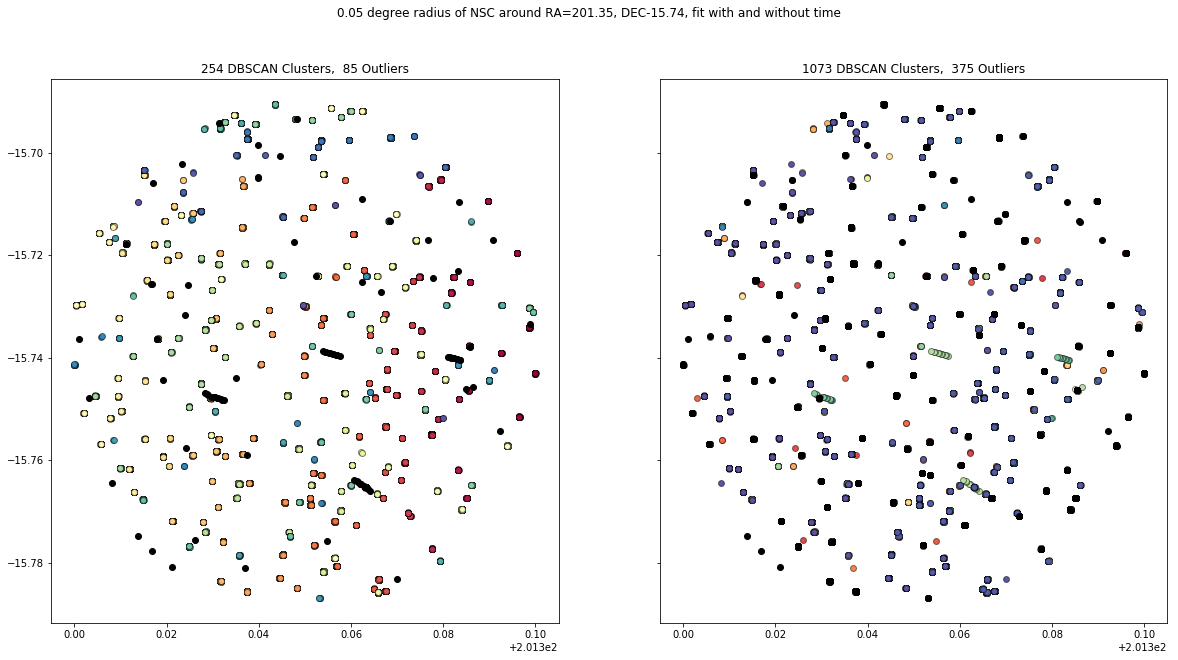

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [655]:
#plot DBSCAN results
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10),sharey=True)                              
f.suptitle("0.05 degree radius of NSC around RA=201.35, DEC-15.74, fit with and without time ")
plot_dbscan(X,db_1,ax1)
plot_dbscan(X_time,db_t,ax2)
plt.show()

## Outliers of DBSCAN (done without time)
no data normalization

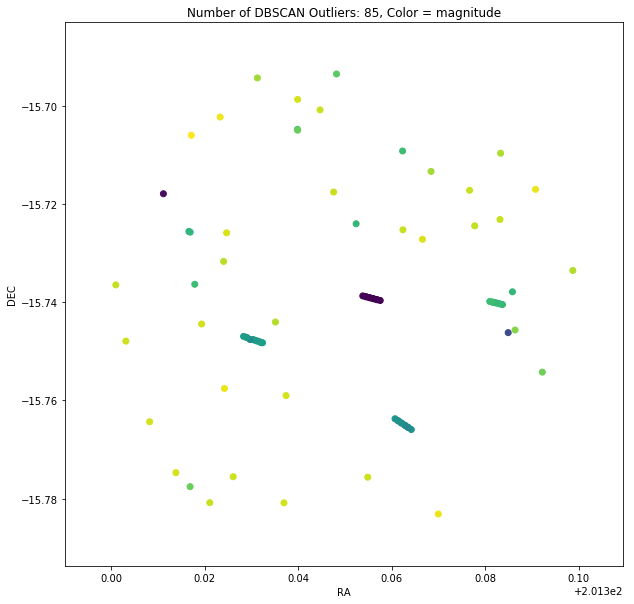

In [657]:
outliers=db_1.labels_==-1 #define outliers from DBSCAN labels
X_out=np.column_stack((np.array(dat_m['ra'][outliers]),np.array(dat_m['dec'][outliers]))) #coordinates of DBSCAN outliers
#plot the outliers (for reference) colored by magnitude--------------------------------------------------------
plt.figure(figsize=(10,10))
plt.scatter(dat_m['ra'][outliers],dat_m['dec'][outliers],c=dat_m['mag_auto'][outliers])
plt.title('Number of DBSCAN Outliers: %d, Color = magnitude' % len(db_1.labels_[outliers]))
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

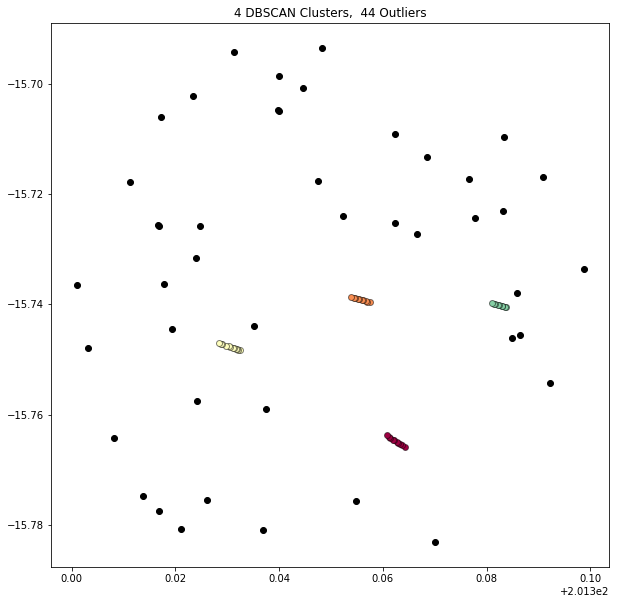

In [659]:
#Compute DBSCAN on outliers without time-----------------------------------------------------
db_2 = DBSCAN(eps=.001, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet
#eps chosen based on size of 'tracklets' - not a great way to do it probably!!
labs = db_2.labels_ #cluster labels
plot_dbscan(X_out,db_2,plt)

# Tracklet Validation

## Select cluster 
I've chosen Cluster 0 (bottom cluster) from the outlier DBSCAN and I'll add some fake data to it to run validation tests.    

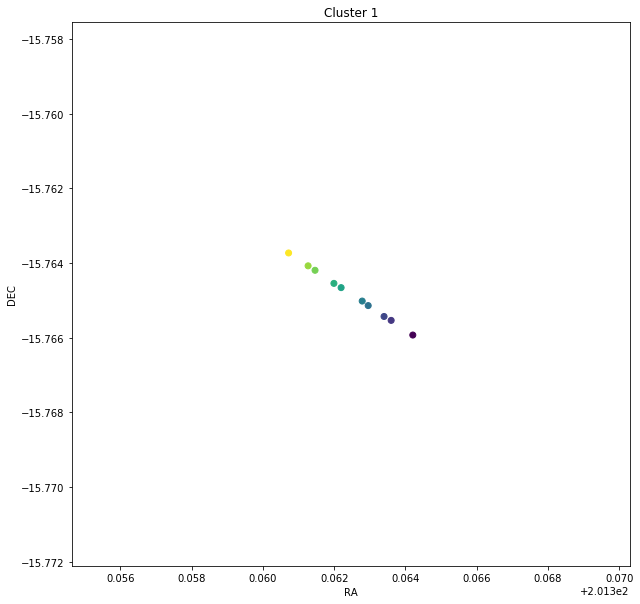

In [664]:
plt.figure(figsize=(10,10))
plt.scatter(dat_m['ra'][outliers][labs==0],dat_m['dec'][outliers][labs==0],c=dat_m['mjd'][outliers][labs==0])
plt.title('Cluster 1')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [665]:
#Cluster #0 with one extra mmt a day later----------------------------------------------------------
c_ex=dat_m[outliers][labs==0]
c_ex.add_row(c_ex[4])
c_ex[10]['mjd']=c_ex[10]['mjd']+0.05
c_ex[10]['dec']=c_ex[10]['dec']+.0001
#Cluster #0 with extra stationary object------------------------------------------------------------
c_s=dat_m[outliers][labs==0]
c_s[:]['ra'] = 201.362285390197
c_s[:]['dec'] = -15.76465803771
c_s[:]['mag_auto'] = 20.1
c_so=join(c_s,dat_m[outliers][labs==0],join_type='outer')

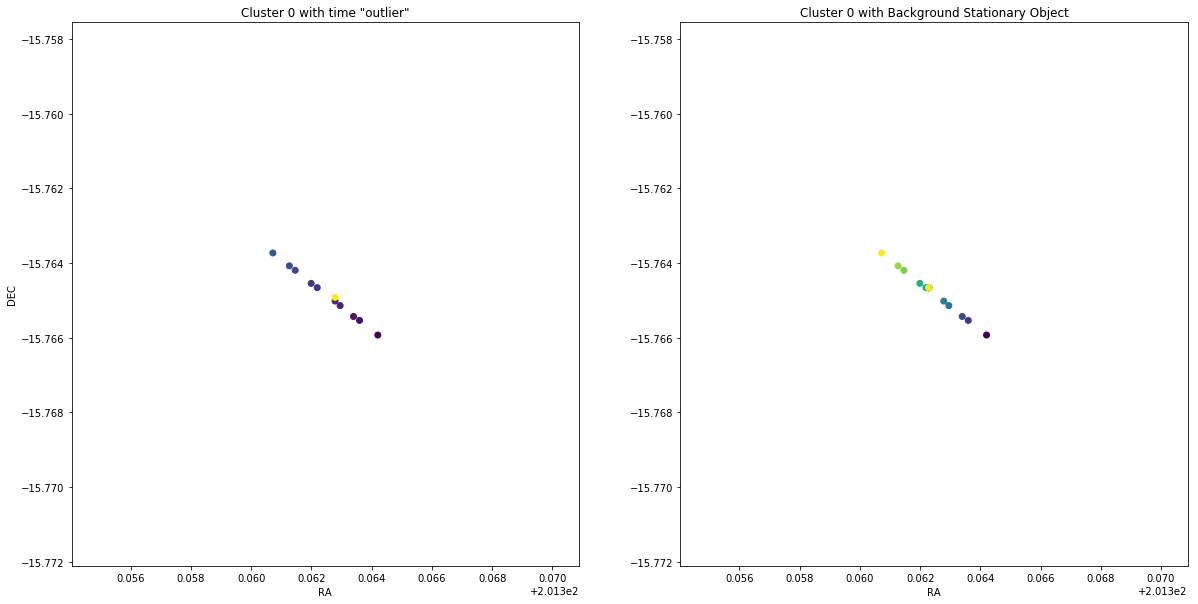

In [667]:
#plot clusters with added data; RA vs DEC, color = time (mjd)
f, (ax2,ax3) = plt.subplots(1, 2,figsize=(20,10)) 
ax2.set_ylabel('DEC')
ax2.scatter(outs_1_ex['ra'],outs_1_ex['dec'],c=outs_1_ex['mjd'])
ax2.set_title('Cluster 0 with time "outlier"')
ax2.set_xlabel('RA')
ax3.scatter(outs_1_so['ra'],outs_1_so['dec'],c=outs_1_so['mjd'])
ax3.set_title('Cluster 0 with Background Stationary Object')
ax3.set_xlabel('RA')
plt.show()

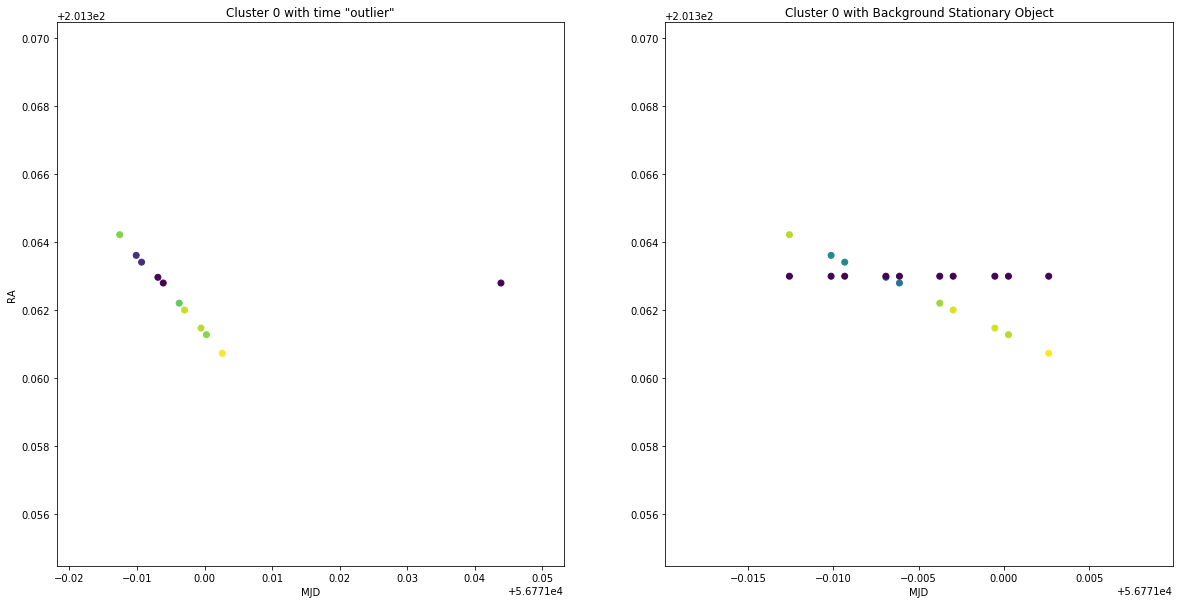

In [669]:
#plot clusters with added data; MJD vs RA, color = magnitude (mag_auto)
f, (ax2,ax3) = plt.subplots(1, 2,figsize=(20,10)) 
ax2.set_ylabel('RA')
ax2.scatter(outs_1_ex['mjd'],outs_1_ex['ra'],c=outs_1_ex['mag_auto'])
ax2.set_title('Cluster 0 with time "outlier"')
ax2.set_xlabel('MJD')
ax3.set_title('Cluster 0 with Background Stationary Object')
ax3.scatter(outs_1['mjd'],outs_1['ra'],c=outs_1['mag_auto'])
ax3.set_xlabel('MJD')
plt.show()

Just for fun, here's a DBSCAN on the tracklet with the time outlier. It doesn't work. Yet

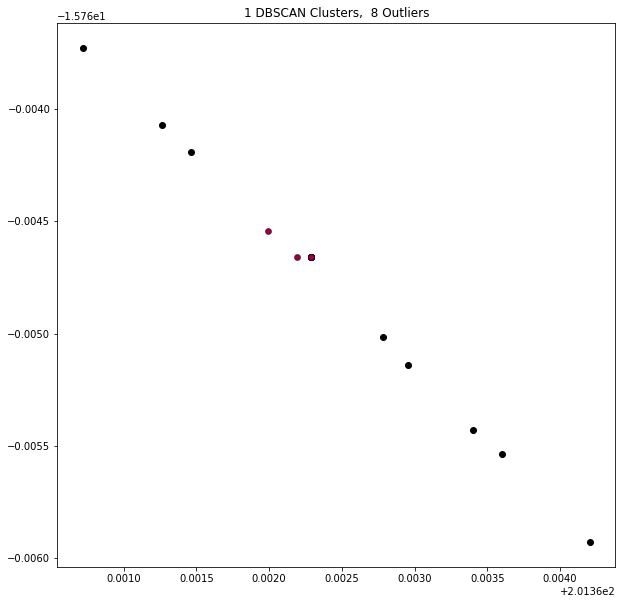

In [673]:
X_test=np.column_stack((np.array(outs_1_so['ra']),np.array(outs_1_so['dec'])))
db_3=DBSCAN(eps=.0005, min_samples=4).fit(X_test)
plot_dbscan(X_test,db_3,plt)

## Reject outlier dates 

Function that gets rid of outlier dates

In [674]:
def reject_outliers(data, m):
    return data[abs(data['mjd'] - np.mean(data['mjd'])) < m * np.std(data['mjd'])],data[abs(data['mjd'] - np.mean(data['mjd'])) > m * np.std(data['mjd'])]

Validate Cluster 1 with the fake time outlier

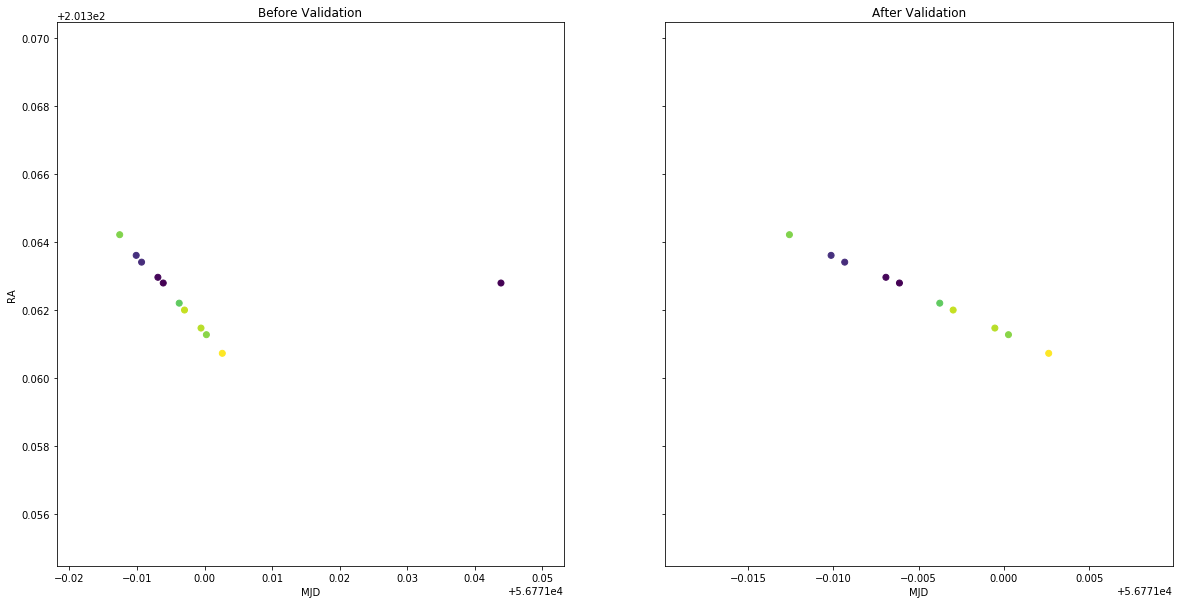

In [676]:
c_valid=reject_outliers(c_ex,1) #validation

#plot results--------------------------------------------------------------------------------
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10),sharey=True) 
ax1.scatter(c_ex['mjd'],c_ex['ra'],c=c_ex['mag_auto'])
ax1.set_title('Before Validation')
ax1.set_xlabel('MJD')
ax1.set_ylabel('RA')
ax2.scatter(c_valid[0]['mjd'],c_valid[0]['ra'],c=c_valid[0]['mag_auto'])
ax2.set_title('After Validation')
ax2.set_xlabel('MJD')
plt.show()

## Best fit line 
resistant to outliers - will do more research on this

In [677]:
def best_fit_plt(data):
    Polynomial = np.polynomial.Polynomial

    ra=data['mjd'][abs(data['mjd'] - np.mean(data['mjd'])) < 1 * np.std(data['mjd'])]
    dec=data['ra'][abs(data['mjd'] - np.mean(data['mjd'])) < 1 * np.std(data['mjd'])]
    ra_all=data['mjd']
    dec_all=data['ra']
    
    cmin, cmax = min(ra), max(ra)
    pfit, stats = Polynomial.fit(ra, dec, 1, full=True, window=(cmin, cmax),domain=(cmin, cmax))

    A0, m = pfit
    resid, rank, sing_val, rcond = stats
    rms = np.sqrt(resid[0]/len(dec))

    plt.scatter(ra_all, dec_all,c=data['mag_auto'])
    plt.plot(ra, pfit(ra), color='k')
    plt.xlabel('MJD')
    plt.ylabel('RA')
    plt.xlim([min(ra_all)-(.1*(max(ra_all)-min(ra_all))),max(ra_all)+(.1*(max(ra_all)-min(ra_all)))])
    plt.ylim([min(dec_all)-(.1*(max(dec_all)-min(dec_all))),max(dec_all)+(.1*(max(dec_all)-min(dec_all)))])
    plt.show()

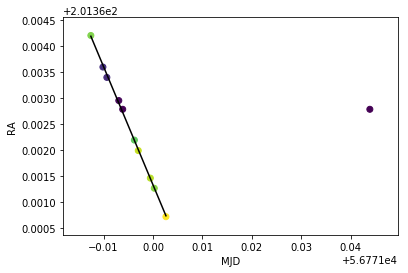

In [678]:
best_fit_plt(outs_1_ex)

# Data Normalization

In [682]:
#create normalized data - I used a module from scikit, which doesn't produce good results. 
X=[np.array(dat_m['ra']),np.array(dat_m['dec']),np.array(dat_m['mjd'])]
transformer = Normalizer(norm='max').fit(X).transform(X)
dat_norm=np.column_stack(transformer)

In [680]:
#match former scale of eps
print('eps = ',(max(transformer[0])-min(transformer[0]))/720.15)

eps =  6.896189898134833e-07


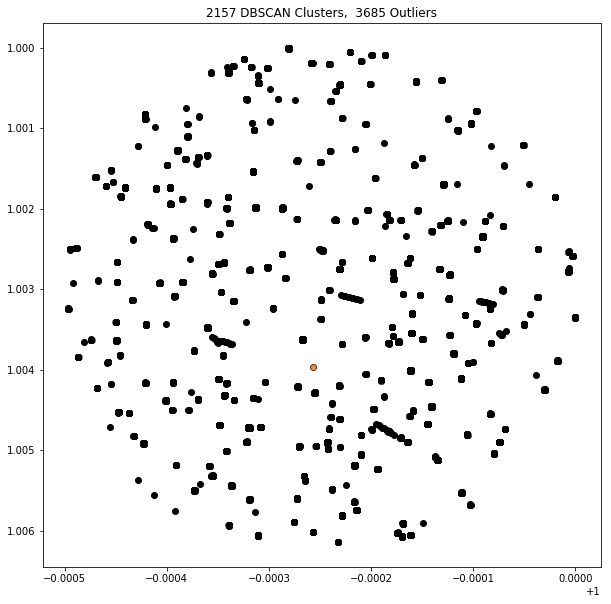

In [681]:
#Compute DBSCAN of normalized data
db_norm=DBSCAN(eps=0.0000006896, min_samples=2).fit(dat_norm)#dbscan with time, data normalized
plot_dbscan(dat_norm,db_norm,plt)
plt.gca().invert_yaxis()
plt.show()

That didn't work at all! I tried a few different values of eps, none work as well as DBSCAN without normalized data. Why not try normalized data on the outliers from the previous dbscan?

In [525]:
#create normalized data
x=[np.array(dat_m[outliers]['ra']),np.array(dat_m[outliers]['dec']),np.array(dat_m[outliers]['mjd'])]
trans = Normalizer(norm='max').fit(x).transform(x)
dat_o_norm=np.column_stack(trans)

In [548]:
#match former scale of eps
print('eps = ',(max(trans[0])-min(trans[0]))/97.83076300399784)

eps =  4.965273309221322e-06


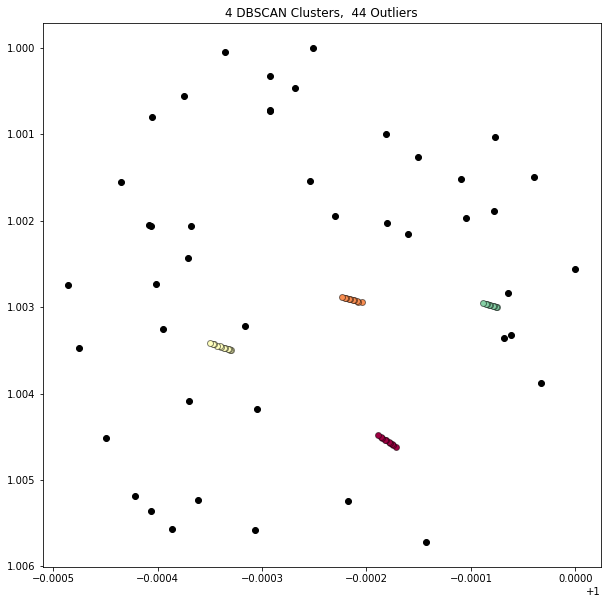

In [552]:
#Compute DBSCAN of normalized outlier data
db_o_norm=DBSCAN(eps=0.00004965, min_samples=3).fit(dat_o_norm)#dbscan with time, outlier data normalized
plot_dbscan(dat_o_norm,db_o_norm,plt)
plt.gca().invert_yaxis()
plt.show()

well.... it WORKS, but not any better than it did without time, or with time and unormalized data...

Next step - do better normalization of data